In [1]:
"""
Created on 3/11/2021 11:56 AM

@author: Tingfeng Li, <tl601@cs.rutgers.edu>, Rutgers University.
"""
import os
import torch
from PIL import Image
import random
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

DEBUG = False

class MNIST_CoLoc(datasets.MNIST):

    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False, digit=4, clutter=0, datapath=None):
        super(MNIST_CoLoc, self).__init__(root, train=train, download=download,
                                          transform=transform, target_transform=target_transform)
        # make sure calling of transform, after which target [x,y,w,h]->[x1,y1,x2,y2]
        assert (self.transform is not None)

        self.digit = digit
        self.datapath = datapath
        self.totensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        self.crop = transforms.RandomResizedCrop((84, 84), scale=(0.1, 1.0))
        if self.datapath is None:
            self.digit_data = [idx for idx, digit in enumerate(self.targets)
                               if digit == self.digit]
            print('total number of digit-{} image\t{}'.format(self.digit, len(self.digit_data)))

            # generate Translated images, put each 28*28 digit at random location in a 84*84
            # black canvas
            self.new_digit_data = np.zeros((len(self.digit_data), 84, 84), dtype=float)
            # note! target style should be [x,y,w, h]
            self.new_targets = torch.zeros((len(self.digit_data), 4), dtype=float)
            for i, idx in enumerate(self.digit_data):
                # sample a location
                # x_d = random.randint(0, 84 - 28)
                # y_d = random.randint(0, 84 - 28)
                x_d = random.randint(14, 42) # at least 1/4 digit in in the center box
                y_d = random.randint(14, 42)
                data = self.data[idx]
                self.new_digit_data[i, y_d:y_d + 28, x_d:x_d + 28] = data
                self.new_targets[i] = torch.tensor([x_d, y_d, 28, 28])
                # add clutter if possible
                if clutter == 1:
                    for _ in range(32): # 16
                        # crop from noise data
                        noise_data = self.data[random.randint(0,len(self.data)-1)]
                        x0 = random.randint(0, 28 - 6)
                        y0 = random.randint(0, 28 - 6)
                        cropped = noise_data[y0:y0+6, x0:x0+6]
                        # sample a location to put cropped noise data
                        x = random.randint(0, 84 - 6)
                        y = random.randint(0, 84 - 6)
                        while np.sum(self.new_digit_data[i, y:y + 6, x:x + 6]) != 0:
                            x = random.randint(0, 84 - 6)
                            y = random.randint(0, 84 - 6)
                        # Insert digit fragment, but not on top of digits
                        if np.sum(self.new_digit_data[i, y:y + 6, x:x + 6]) == 0:
                            self.new_digit_data[i, y:y + 6, x:x + 6] = cropped

                        # Clip any over-saturated pixels
                        self.new_digit_data[i] = np.clip(self.new_digit_data[i], 0, 255)

            # keep 400 images
            # inds = np.random.permutation(len(self.digit_data))
            # keep = 400 if train else 100
            # self.new_digit_data = self.new_digit_data[inds[:keep]]
            # self.new_targets = self.new_targets[inds[:keep]]
        else:
            phase = 'train' if train else 'test'
            datadir = os.path.join(self.datapath, phase)
            if clutter == 1:
                self.new_digit_data = np.load(os.path.join(datadir, 'moreclutter',
                                                           str(digit) + '_moreclutter_data.npy'))
                self.new_targets = np.load(os.path.join(datadir, 'moreclutter',
                                                        str(digit) + '_moreclutter_label.npy'))
            elif clutter == 0:
                self.new_digit_data = np.load(os.path.join(datadir, 'clean',
                                                           str(digit)+'_data.npy'))
                self.new_targets = np.load(os.path.join(datadir, 'clean',
                                                        str(digit) + '_label.npy'))
                self.new_targets[self.new_targets == 84] -= 1
                assert(np.max(self.new_targets) == 83)
        self.new_targets = torch.from_numpy(self.new_targets)

    def __getitem__(self, index):
        img, target = self.new_digit_data[index], self.new_targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img, target = self.transform(img, target)

        if DEBUG:
            f, ax = plt.subplots()
            x1, y1, x2, y2 = target
            ax.imshow(np.asarray(img), cmap='gray', interpolation='none')
            patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1,
                              edgecolor='g', facecolor='none', fill=False)
            ax.add_patch(patch)

        img = self.totensor(img)

        if self.target_transform is not None:
            target_new = self.target_transform(target)
            ti, tj, iou1, iou2 = target_new[0][0], target_new[0][1], \
                                 target_new[1][0], target_new[1][1]

        if DEBUG:
            print('ti ', ti, ' tj ', tj)
            print('ious ', iou1, ' ', iou2)
            patch = Rectangle((ti[0], ti[1]), ti[2]-ti[0], ti[3]-ti[1], linewidth=1,
                              edgecolor='r', facecolor='none', fill=False)
            ax.add_patch(patch)
            patch = Rectangle((tj[0], tj[1]), tj[2] - tj[0], tj[3] - tj[1], linewidth=1,
                              edgecolor='y', facecolor='none', fill=False)
            ax.add_patch(patch)
            plt.show()
            exit()
        #print('target new ', target)
        return img, target, ti, tj, iou1, iou2

    def __len__(self):
        return self.new_digit_data.shape[0]

    @property
    def raw_folder(self):
        return os.path.join('/research/cbim/vast/tl601/Dataset', 'MNIST', 'raw')

    @property
    def processed_folder(self):
        return os.path.join('/research/cbim/vast/tl601/Dataset', 'MNIST', 'processed')

ioui  (5842,)


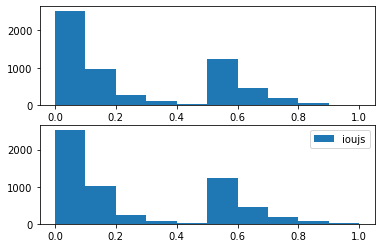

In [2]:
import sys
sys.path.append('..')
import torch
from util.data_aug import *
from util.augmentations import Compose
from transform import MyBoxScaleTransform
kwargs = {'num_workers': 8, 'pin_memory': True}

train_transform = Compose([Resize(84)])
test_transform = Compose([Resize(84)])
trainset = MNIST_CoLoc(root='.', train=True, digit=4,
                       datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                       clutter=1, transform=train_transform,
                       target_transform=MyBoxScaleTransform())
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=512, shuffle=True, **kwargs)

iouis, ioujs = [], []
for i, (data, target, ti, tj, iou1, iou2 ) in enumerate(train_loader):
    iouis.append(iou1)
    ioujs.append(iou2)

iouis = torch.cat(iouis).numpy()
ioujs = torch.cat(ioujs).numpy()
print('ioui ', iouis.shape)
f, ax = plt.subplots(2,1)
ax[0].hist(iouis, label='iouis')
ax[1].hist(ioujs, label='ioujs')
plt.legend()
plt.show()